# PSF Photometry on Spitzer data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.wcs import wcs

In [2]:
catalog = Table.read("/Users/jvmirca/Projects/photutils-datasets/data/spitzer_example_catalog.xml")
l = catalog['l']
b = catalog['b']
fluxes_catalog = catalog['f4_5']

In [3]:
data = fits.getdata('/Users/jvmirca/Projects/photutils-datasets/data/spitzer_example_image.fits')
factor = (u.MJy / u.sr * (1.2 * u.arcsec) ** 2 / u.pixel).to(u.mJy / u.pixel)
data *= factor.value
mask = np.isfinite(data)

In [4]:
header = fits.getheader("/Users/jvmirca/Projects/photutils-datasets/data/spitzer_example_image.fits")
wcs_transform = wcs.WCS(header)
coords = wcs_transform.wcs_world2pix(list(zip(l, b)), 0)

coords.T[0] += 0.18
coords.T[1] += 0.3

positions = Table(names=['x_0', 'y_0'], data=[coords.T[0], coords.T[1]])

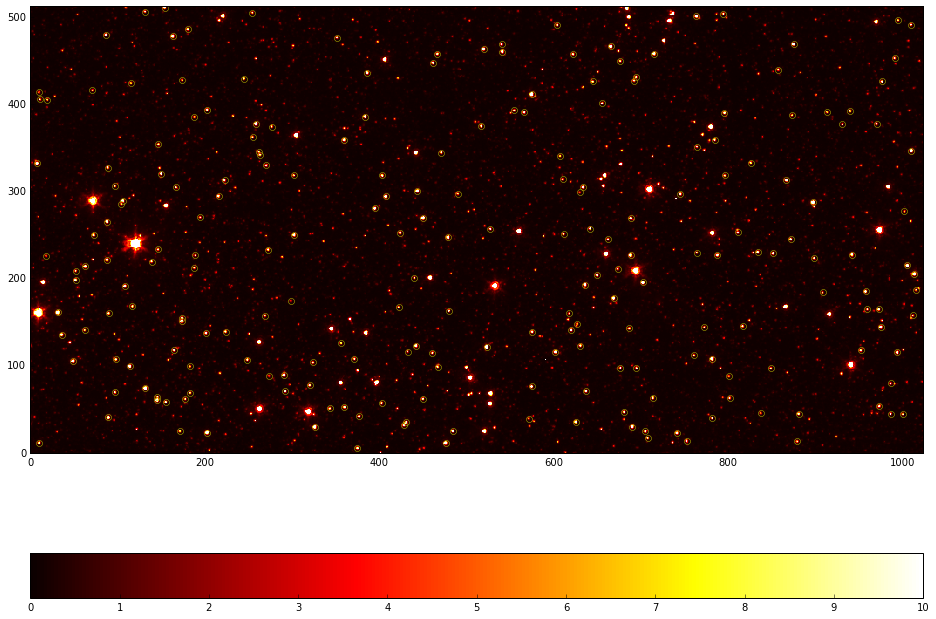

In [5]:
plt.figure(figsize=(16, 12))
plt.imshow(data, cmap='hot', vmin=0, vmax=10, interpolation='None', origin='lower')
plt.xlim(0, 1024)
plt.ylim(0, 512)
plt.plot(coords.T[0], coords.T[1], marker="o", markerfacecolor='None', markeredgecolor='y', linestyle='None')
plt.colorbar(orientation='horizontal')

In [6]:
from photutils import DAOPhotPSFPhotometry
from photutils import DAOGroup
from photutils.psf import IntegratedGaussianPRF
from photutils.background import MedianBackground
from astropy.stats import gaussian_sigma_to_fwhm

In [7]:
daogroup = DAOGroup(1.0*gaussian_sigma_to_fwhm)
median_bkg = MedianBackground(sigma=3.)
psf_model = IntegratedGaussianPRF(sigma=1.0)

In [8]:
my_photometry = DAOPhotPSFPhotometry(group=daogroup, bkg=median_bkg,
                                     psf=psf_model, fitshape=(3,3))

In [9]:
result_tab, residual_image = my_photometry(image=data, positions=positions)

/Users/jvmirca/Projects/astropy/astropy/stats/sigma_clipping.py:179: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/jvmirca/Projects/astropy/astropy/stats/sigma_clipping.py:180: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


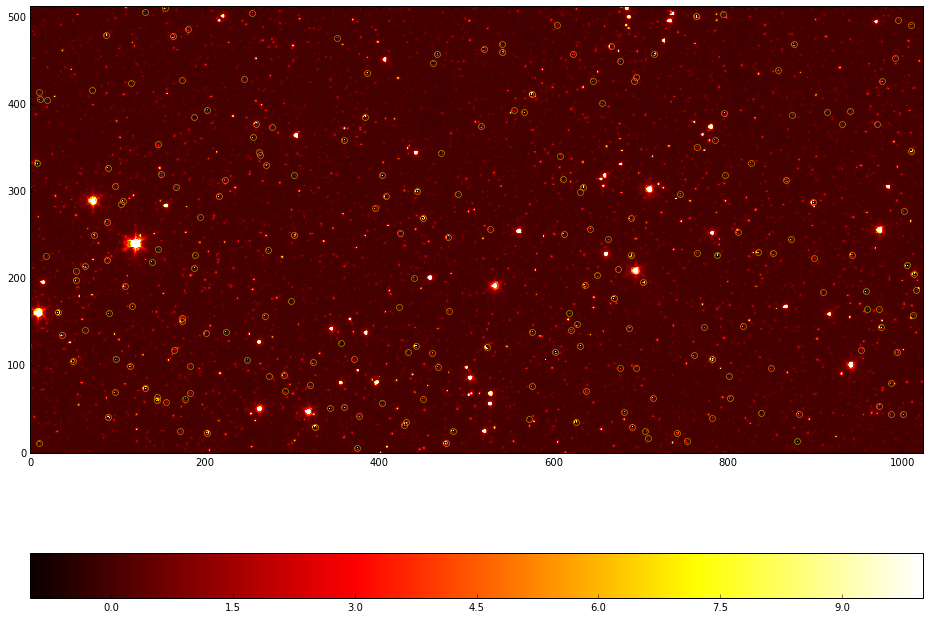

In [10]:
plt.figure(figsize=(16, 12))
plt.imshow(residual_image, cmap='hot', vmin=-1, vmax=10, interpolation='None', origin='lower')
plt.plot(coords.T[0], coords.T[1], marker="o", markerfacecolor='None', markeredgecolor='y', linestyle='None')
plt.xlim(0, 1024)
plt.ylim(0, 512)
plt.colorbar(orientation='horizontal')

In [11]:
result_tab.sort('id')

 id group_id     x_fit         y_fit        flux_fit  
--- -------- ------------- ------------- -------------
  1        1 7.77052143675 331.811095762 204.593203926
  2        2 18.0417697937 225.853351874 57.2569562094
  3        3 11.1502511629 405.226014586 64.6198617511
  4        4 19.5486666848 404.877401991 51.1381398033
  5        5 131.616329426 505.914348795 63.1510562614
  6        6 86.9159750094 479.322758413 185.648687346
  7        7 154.038266647 510.574862652 160.144552151
  8        8  165.23481618 117.256638021 184.112224336
  9        9 173.776897131  150.82934232 413.388505427
 10       10 146.290718681 233.117514858 72.2533109524
...      ...           ...           ...           ...
214      214 686.941474467  142.48162964 113.232680646
215      215 676.619834722 449.417394976 74.9256053778
216      216 517.273922419 374.594706999 120.054694918
217      217 772.812475088 143.981994727 62.8197760848
218      218 566.616949337 390.353248678 109.277878486
219      2

##### Let's compare the photometry results with the catalog

0.99551121627
21.85636784970891 mJy


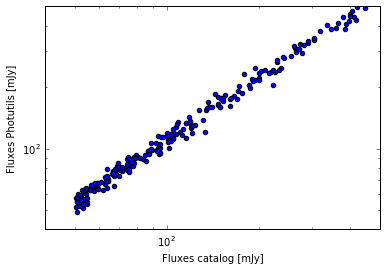

In [13]:
plt.scatter(fluxes_catalog, result_tab['flux_fit'])
plt.loglog()
plt.xlim(40, 500)
plt.ylim(40, 500)
plt.xlabel("Fluxes catalog [mJy]")
plt.ylabel("Fluxes Photutils [mJy]")

##### Let's also compute the correlation coefficient and the root mean squared error between the fluxes in the catalog and the estimated fluxes

In [14]:
print(np.corrcoef(fluxes_catalog, result_tab['flux_fit'])[0][1])
print(np.sqrt(np.mean((fluxes_catalog - result_tab['flux_fit'])**2))*u.mJy)

0.99551121627
21.85636784970891 mJy
